# Course 4 Module 4 Lesson 3 Screencasts

## M4L3SC1: GANs vs. VAEs vs. Diffusion: Demonstration of use cases

### Step 1: VAE Example Setup

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Step 2: Download & Prepare ECG Data


In [ ]:
url = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
df = pd.read_csv(url)

print(df.head())

# Separate labels
raw_data = df.values
X = raw_data[:, 0:-1]
y = raw_data[:, -1]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train only on normal (label=0)
X_train = X_scaled[y == 0]
X_test = X_scaled
y_test = y

   -0.11252183  -2.8272038  -3.7738969  -4.3497511  -4.376041  -3.4749863  \
0    -1.100878   -3.996840   -4.285843   -4.506579  -4.022377   -3.234368   
1    -0.567088   -2.593450   -3.874230   -4.584095  -4.187449   -3.151462   
2     0.490473   -1.914407   -3.616364   -4.318823  -4.268016   -3.881110   
3     0.800232   -0.874252   -2.384761   -3.973292  -4.338224   -3.802422   
4    -1.507674   -3.574550   -4.478011   -4.408275  -3.321242   -2.105171   

   -2.1814082  -1.8182865  -1.2505219  -0.47749208  ...  0.79216787  \
0   -1.566126   -0.992258   -0.754680     0.042321  ...    0.538356   
1   -1.742940   -1.490659   -1.183580    -0.394229  ...    0.886073   
2   -2.993280   -1.671131   -1.333884    -0.965629  ...    0.350816   
3   -2.534510   -1.783423   -1.594450    -0.753199  ...    1.148884   
4   -1.481048   -1.301362   -0.498240    -0.286928  ...    1.089068   

   0.93354122  0.79695779  0.57862066  0.2577399  0.22807718  0.12343082  \
0    0.656881    0.787490    0.724

### Step 3: Define VAE Architecture

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=140, latent_dim=8):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.mu = nn.Linear(32, latent_dim)
        self.logvar = nn.Linear(32, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

### Step 4: Train VAE


In [ ]:
def vae_loss(x, x_hat, mu, logvar):
    recon = F.mse_loss(x_hat, x, reduction="mean")
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)

for epoch in range(500):
    model.train()
    x_hat, mu, logvar = model(X_train_tensor)
    loss = vae_loss(X_train_tensor, x_hat, mu, logvar)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}")

Epoch 0 - Loss: 1.3080
Epoch 50 - Loss: 0.9453
Epoch 100 - Loss: 0.9174
Epoch 150 - Loss: 0.7755
Epoch 200 - Loss: 0.7260
Epoch 250 - Loss: 0.6902
Epoch 300 - Loss: 0.6741
Epoch 350 - Loss: 0.6573
Epoch 400 - Loss: 0.6502
Epoch 450 - Loss: 0.6438


### Step 5: Inference and Evaluation

In [ ]:
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    X_recon, _, _ = model(X_test_tensor)
    recon_error = torch.mean((X_recon - X_test_tensor) ** 2, dim=1).cpu().numpy()

# Threshold: 95th percentile of normal recon error
threshold = np.percentile(recon_error[y_test == 0], 95)
y_pred = (recon_error > threshold).astype(int)

print(classification_report(y_test, y_pred, target_names=["Normal", "Anomaly"]))
print("ROC AUC:", roc_auc_score(y_test, recon_error))

              precision    recall  f1-score   support

      Normal       0.50      0.95      0.66      2079
     Anomaly       0.90      0.33      0.49      2918

    accuracy                           0.59      4997
   macro avg       0.70      0.64      0.57      4997
weighted avg       0.74      0.59      0.56      4997

ROC AUC: 0.9452544637602898


### Step 6: Visualize Some Reconstruction Examples

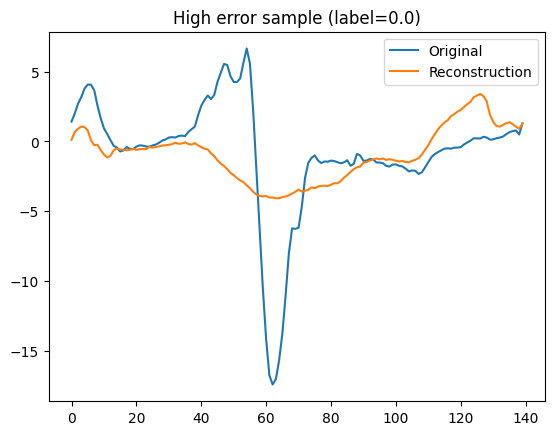

In [ ]:
i = np.argmax(recon_error)
plt.plot(X_test[i], label="Original")
plt.plot(X_recon[i].cpu(), label="Reconstruction")
plt.title(f"High error sample (label={y_test[i]})")
plt.legend()
plt.show()

### Step 1: GAN Example Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Step 2: Generate an Imbalanced Data Set that is Easily Visualized

In [ ]:
# Generate 2D data
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
    n_clusters_per_class=1, weights=[0.9, 0.1], random_state=42
)

# Separate classes
X_minority = X[y == 1]
X_majority = X[y == 0]

print(f"Class balance: {len(X_minority)} minority, {len(X_majority)} majority")

Class balance: 105 minority, 895 majority


### Step 3: Define the GAN Architecture

In [ ]:
latent_dim = 10
data_dim = 2

# Generator: noise -> 2D point
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, data_dim)
        )

    def forward(self, z):
        return self.model(z)

# Discriminator: 2D point -> real/fake
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

### Step 4: Train the GAN on Minority Observations

In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)

loss_fn = nn.BCELoss()
g_opt = torch.optim.Adam(G.parameters(), lr=1e-3)
d_opt = torch.optim.Adam(D.parameters(), lr=1e-3)

real_data = torch.tensor(X_minority, dtype=torch.float32).to(device)
batch_size = 32

for epoch in range(600):
    # === Train Discriminator ===
    idx = np.random.randint(0, real_data.shape[0], batch_size)
    real_batch = real_data[idx]
    real_labels = torch.ones(batch_size, 1).to(device)

    z = torch.randn(batch_size, latent_dim).to(device)
    fake_batch = G(z)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    d_loss_real = loss_fn(D(real_batch), real_labels)
    d_loss_fake = loss_fn(D(fake_batch.detach()), fake_labels)
    d_loss = d_loss_real + d_loss_fake

    d_opt.zero_grad()
    d_loss.backward()
    d_opt.step()

    # === Train Generator ===
    z = torch.randn(batch_size, latent_dim).to(device)
    fake_batch = G(z)
    g_loss = loss_fn(D(fake_batch), real_labels)  # Fool the discriminator

    g_opt.zero_grad()
    g_loss.backward()
    g_opt.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}: D loss = {d_loss.item():.4f}, G loss = {g_loss.item():.4f}")

Epoch 0: D loss = 1.3745, G loss = 0.6073
Epoch 200: D loss = 1.2236, G loss = 0.8904
Epoch 400: D loss = 1.3807, G loss = 1.2892


### Step 5: Generate Synthesized Minority Observations

In [ ]:
G.eval()
with torch.no_grad():
    z = torch.randn(500, latent_dim).to(device)
    synthetic_minority = G(z).cpu().numpy()

# Combine with original data
X_augmented = np.vstack([X, synthetic_minority])
y_augmented = np.concatenate([y, np.ones(len(synthetic_minority))])

### Step 6: Visualize the Balanced Data Set

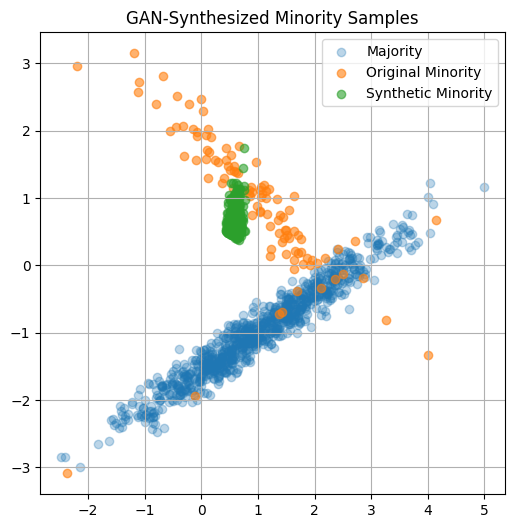

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], alpha=0.3, label="Majority")
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], alpha=0.6, label="Original Minority")
plt.scatter(synthetic_minority[:, 0], synthetic_minority[:, 1], alpha=0.6, label="Synthetic Minority")
plt.legend()
plt.title("GAN-Synthesized Minority Samples")
plt.grid(True)
plt.show()

### Step 1: Diffusion Example Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

### Step 2: Simulate Patient Trajectory Data

In [ ]:
# Simulate 1000 patients, each with 5 features (e.g., HR, BP, Temp, SpO2, risk)
n_patients = 1000
n_features = 5
timesteps = 10

np.random.seed(42)
trajectories = []

for _ in range(n_patients):
    base = np.random.rand(n_features)
    trend = np.random.randn(n_features) * 0.1
    patient = [base + t * trend + np.random.randn(n_features) * 0.01 for t in range(timesteps)]
    trajectories.append(patient)

data = np.array(trajectories)  # shape: (1000, 10, 5)
print("Simulated data shape:", data.shape)

Simulated data shape: (1000, 10, 5)


### Step 3: Prepare Diffusion Noise Schedule

In [ ]:
def linear_beta_schedule(timesteps, start=1e-4, end=0.02):
    return torch.linspace(start, end, timesteps)

T = 100  # diffusion steps
betas = linear_beta_schedule(T).to("cpu")
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

### Step 4: Define Denoising Diffusion Architecture

In [ ]:
class Denoiser(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(feature_dim + 1, 64),
            nn.ReLU(),
            nn.Linear(64, feature_dim)
        )

    def forward(self, x, t):
        # Add timestep as a feature
        t_embed = t.unsqueeze(1).float() / T
        x_input = torch.cat([x, t_embed], dim=1)
        return self.model(x_input)

model = Denoiser(n_features).to('cpu')

### Step 5: Add Noise and Train the Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Flatten trajectories: (samples, features)
flat_data = torch.tensor(data[:, -1, :], dtype=torch.float32)  # predict last step only

for epoch in range(1000):
    idx = torch.randint(0, flat_data.shape[0], (64,))
    x0 = flat_data[idx]

    t = torch.randint(0, T, (x0.shape[0],))
    noise = torch.randn_like(x0)

    alpha_t = alphas_cumprod[t].unsqueeze(1)
    xt = torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * noise

    noise_pred = model(xt, t)
    loss = loss_fn(noise_pred, noise)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 1.0577
Epoch 100, Loss: 0.8293
Epoch 200, Loss: 0.7470
Epoch 300, Loss: 0.7291
Epoch 400, Loss: 0.7098
Epoch 500, Loss: 0.7297
Epoch 600, Loss: 0.7255
Epoch 700, Loss: 0.7113
Epoch 800, Loss: 0.7747
Epoch 900, Loss: 0.7356


### Step 6: Sample Future Patient Outcomes via Reverse Diffusion

In [ ]:
def sample(model, shape):
    x = torch.randn(shape)
    for t in reversed(range(T)):
        t_tensor = torch.full((shape[0],), t)
        noise_pred = model(x, t_tensor)
        alpha = alphas[t]
        alpha_bar = alphas_cumprod[t]
        beta = betas[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (1 / torch.sqrt(alpha)) * (x - beta / torch.sqrt(1 - alpha_bar) * noise_pred) + torch.sqrt(beta) * noise
    return x

with torch.no_grad():
    samples = sample(model, (100, n_features)).numpy()

### Step 7: Visualize and Compare Distributions

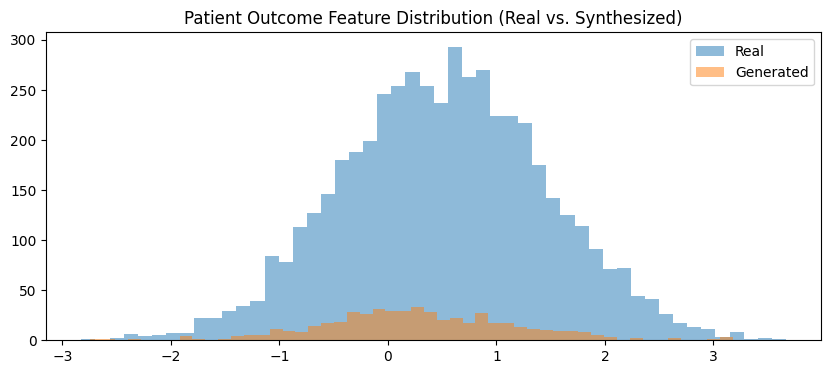

In [ ]:
plt.figure(figsize=(10, 4))
plt.hist(flat_data.numpy().flatten(), bins=50, alpha=0.5, label="Real")
plt.hist(samples.flatten(), bins=50, alpha=0.5, label="Generated")
plt.legend()
plt.title("Patient Outcome Feature Distribution (Real vs. Synthesized)")
plt.show()